# Check 3D pdf learned by NN

In [1]:
import jax
import jax.numpy as np
import numpy as onp
import jax.random as rjax
import flax
from flax import nn, optim, serialization
import matplotlib.pyplot as plt

In [2]:
from lib.params import mdn, mdstp, mpip

In [3]:
import matplotlib.pyplot as plt

In [4]:
mc = np.load('mc_ddpip_3d_v2_100ch_smeared.npy')
mc.shape

(168766, 3)

In [5]:
train_frac = 0.8
train_edge = int(mc.shape[0]*train_frac)
mc_train, mc_test = mc[:train_edge], mc[train_edge:]
mc_train.shape, mc_test.shape

((135012, 3), (33754, 3))

In [6]:
def get_vars(data):
    """ """
    e, mddsq, md1pisq = [data[:,i] for i in range(3)]
    tdd = (np.sqrt(mddsq) - 2*mdn)*10**3
    mask = tdd > 0
    pd = np.sqrt(np.clip(tdd, 0, None) * mdn * 10**3)
    md1pi = np.sqrt(md1pisq)
    return np.column_stack([e[mask], pd[mask], md1pi[mask]])

In [7]:
data_train, data_test = [get_vars(x) for x in [mc_train, mc_test]]
data_train.shape, data_test.shape

/home/vitaly/miniconda3/envs/tf2/lib/python3.8/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


((133257, 3), (33309, 3))

In [8]:
def draw_1d_projections(ax, data, bins=250, weights=None):
    ax[0].hist(data[:,0], bins=bins, weights=weights);
    ax[0].set_xlim((-2.5, 10))
    ax[0].grid()
    ax[0].set_xlabel(r'$E (MeV)$')

    ax[1].hist(data[:,1], bins=bins, weights=weights);
    ax[1].set_xlabel(r'$p(D^0)$ (MeV)')
    ax[1].set_xlim((0, 120))
    ax[1].grid()

    ax[2].hist(data[:,2], bins=bins, weights=weights);
    ax[2].set_xlabel(r'$m(D^0pi^+)$ (GeV)')
    # ax[2].set_xlim((2.004, 2.026))
    ax[2].grid()

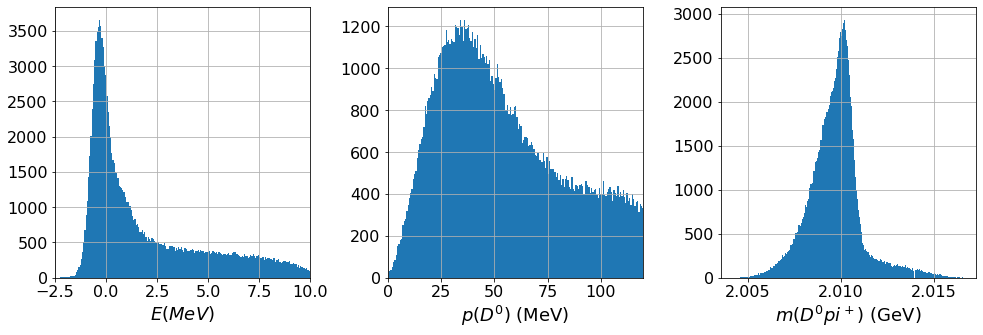

In [9]:
fig, ax = plt.subplots(ncols=3, figsize=(14,5))
draw_1d_projections(ax, data_train)
fig.tight_layout()

In [10]:
def hist_2d(x, y, rng=None, bins=50, weights=None):
    hist, xbins, ybins = onp.histogram2d(x, y, bins=bins, range=rng, weights=weights)
    xbins = 0.5 * (xbins[:-1] + xbins[1:])
    ybins = 0.5 * (ybins[:-1] + ybins[1:])
    xv, yv = onp.meshgrid(xbins, ybins)
    return (xv, yv, hist.T)

In [11]:
def put_contours(ax, x, y, bins=20, levels=6, weights=None):
    ax.contourf(*hist_2d(x=x, y=y, rng=None, bins=[bins,bins], weights=weights), levels=levels)

In [12]:
def draw_2d_projections(ax, data, bins=20, lebels=6, weights=None):
    d = data[(data[:,0] > -1.5) & (data[:,0] < 2.5) & (data[:,1] < 80)]

    bins, contours = 20, 6
    put_contours(ax[0], d[:,0], d[:,1], bins, contours, weights)
    ax[0].grid()

    put_contours(ax[1], d[:,0], d[:,2], bins, contours, weights)
    ax[1].set_ylim((2.007, 2.011))
    ax[1].grid()

    put_contours(ax[2], d[:,1], d[:,2], bins, contours, weights)
    ax[2].set_ylim((2.007, 2.011))
    ax[2].grid()

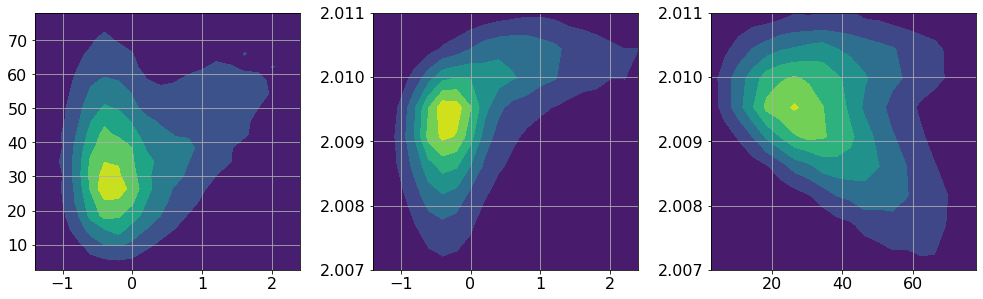

In [13]:
fig, ax = plt.subplots(ncols=3, figsize=(14,4.5))
draw_2d_projections(ax, data_train)
fig.tight_layout()

Load NN model

In [14]:
@flax.struct.dataclass
class TrainState:
    optimizer: optim.Optimizer

In [15]:
class NN(nn.Module):
    def apply(self, x):
        x = nn.Dense(x, features=32)
        x = nn.sigmoid(x)
        x = nn.Dense(x, features=32)
        x = nn.sigmoid(x)
        x = nn.Dense(x, features=1)
        return nn.sigmoid(x)

In [16]:
def do_fit(data, steps=100, lbl='', test_data=None):
    """ """
    test_provided = test_data is not None
    
    norm_sample_size = 10**6
    norm_space = (
        (-2.5, 10),  # energy range (MeV)
        (0, 120),  # p(D) range (MeV)
        (2.005, 2.016),  # m(Dpi) range (GeV)
    )

    _, initial_params = NN.init(rjax.PRNGKey(0), data)
    print('Model initialized:')
    print(jax.tree_map(np.shape, initial_params))

    rng = rjax.PRNGKey(10)
    rng, key1, key2, key3 = rjax.split(rng, 4)
    keys = [key1, key2, key3]
    norm_sample = np.column_stack([
        rjax.uniform(rjax.PRNGKey(key[0]), (norm_sample_size,), minval=lo, maxval=hi)\
            for key, (lo, hi) in zip(keys, norm_space)
    ])
    
    def l2_loss(model, lmbd=1e-3):
        l2 = 0
        for _, layer in model.params.items():
            l2 += np.sum(layer['kernel']**2)
        return lmbd*l2

    def loglh_loss(model, evts):
        """ loss function for the unbinned maximum likelihood fit """
        return -np.sum(np.log(model(evts))) +\
            data.shape[0] * np.log(np.sum(model(norm_sample)))
#             + l2_loss(model)*data.shape[0]
    
    train_loss_fcn = lambda model: loglh_loss(model, data)
    if test_data is not None:
        test_loss_fcn = lambda model: loglh_loss(model, test_data)
    
    model = nn.Model(NN, initial_params)
    adam = optim.Adam(learning_rate=0.03)
    optimizer = adam.create(model)

    history = {'loss': []}
    if test_provided:
        history['test_loss'] = []
        
    for i in range(steps):
        train_loss, grad = jax.value_and_grad(train_loss_fcn)(optimizer.target)
        optimizer = optimizer.apply_gradient(grad)
        history['loss'].append(train_loss)
        if test_provided:
            test_loss = test_loss_fcn(optimizer.target)
            history['test_loss'].append(test_loss)
            print(f'{i:4d}/{steps:<4d} loss: {train_loss:<12.3f}\t tloss: {test_loss:<12.3f}')
        else:
            print(f'{i}/{steps}: loss: {train_loss:.3f}')


    with open(f'nn_model_3d_{lbl}.dat', 'wb') as ofile:
        state = TrainState(optimizer=optimizer)
        data = flax.serialization.to_bytes(state)
        print(f'Model serialized, num bytes: {len(data)}')
        ofile.write(data)

    return (history, norm_sample, optimizer.target)

In [17]:
history, norm_sample, trained_model = do_fit(data_train, steps=150, lbl='test_fit', test_data=data_test)

Model initialized:
{'Dense_0': {'bias': (32,), 'kernel': (3, 32)}, 'Dense_1': {'bias': (32,), 'kernel': (32, 32)}, 'Dense_2': {'bias': (1,), 'kernel': (32, 1)}}
   0/150  loss: 1841312.375 	 tloss: 1786638.125 
   1/150  loss: 1838584.625 	 tloss: 1781917.000 
   2/150  loss: 1835352.125 	 tloss: 1764713.000 
   3/150  loss: 1831081.125 	 tloss: 1738004.500 
   4/150  loss: 1824018.750 	 tloss: 1701803.125 
   5/150  loss: 1816640.500 	 tloss: 1663904.250 
   6/150  loss: 1809055.500 	 tloss: 1633028.750 
   7/150  loss: 1800489.750 	 tloss: 1609375.250 
   8/150  loss: 1792255.375 	 tloss: 1601144.375 
   9/150  loss: 1788666.750 	 tloss: 1622708.000 
  10/150  loss: 1782194.625 	 tloss: 1650314.875 
  11/150  loss: 1777512.375 	 tloss: 1657498.375 
  12/150  loss: 1774283.625 	 tloss: 1643652.875 
  13/150  loss: 1770269.250 	 tloss: 1612225.250 
  14/150  loss: 1766864.250 	 tloss: 1598610.000 
  15/150  loss: 1763395.750 	 tloss: 1610098.125 
  16/150  loss: 1759996.750 	 tloss: 16

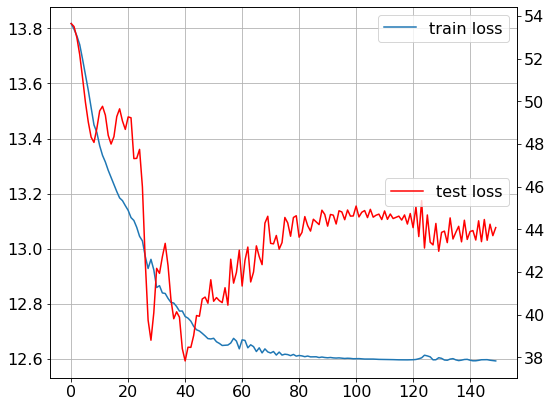

In [18]:
fig, ax = plt.subplots(figsize=(8,6))
x = list(range(len(history['loss'])))
loss = np.array(history['loss']) / data_train.shape[0]
test_loss = np.array(history['test_loss']) / data_test.shape[0]
ax.plot(x, loss, label='train loss')
ax2 = ax.twinx()
ax2.plot(x, test_loss, label='test loss', c='r')
ax.legend(fontsize=16)
ax2.legend(fontsize=16, loc=5)
ax.grid()
fig.tight_layout()

In [19]:
jax.tree_map(np.shape, trained_model.params)

{'Dense_0': {'bias': (32,), 'kernel': (3, 32)},
 'Dense_1': {'bias': (32,), 'kernel': (32, 32)},
 'Dense_2': {'bias': (1,), 'kernel': (32, 1)}}

In [20]:
weights = onp.array(trained_model(norm_sample))

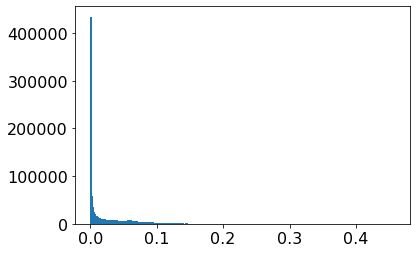

In [21]:
plt.hist(weights, bins=250);

In [22]:
weights.mean()

0.03612108

In [23]:
weights.std()

0.07221597

In [24]:
weights.flatten().shape, norm_sample[:,0].shape

((1000000,), (1000000,))

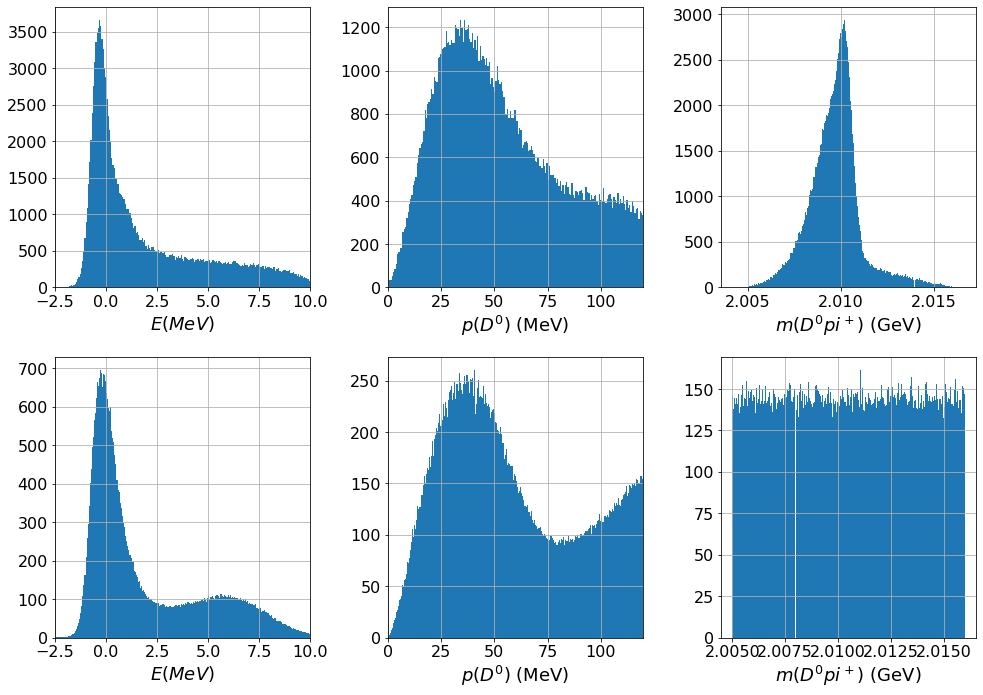

In [25]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(14,10))
draw_1d_projections(ax[0], data_train)
draw_1d_projections(ax[1], norm_sample, weights=weights.flatten())
fig.tight_layout()

In [26]:
# _, initial_params = NN.init(rjax.PRNGKey(0), data)

In [27]:
# model = nn.Model(NN, initial_params)
#     adam = optim.Adam(learning_rate=0.03)
#     optimizer = adam.create(model)

In [28]:
# with open('nn_model_3d.dat', 'wb') as ofile:
#     state = TrainState(optimizer=optimizer)
#     data = flax.serialization.to_bytes(state)
#     print(f'Model serialized, num bytes: {len(data)}')
#     ofile.write(data)